In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from glob import glob
import json
import os
from os.path import join, dirname, basename

from tensorflow.keras.models import load_model
import geopandas
import numpy as np
import rasterio as rio
from rasterio.windows import Window
from shapely.geometry import Polygon

from dataset import preprocess_input

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import yaml

try:
    with open('malawi_config.yaml') as config_file:
        config = yaml.safe_load(config_file)
except Exception as e:
    print('Could not load configurations file')
    raise e

model_name = 'xception-balanced-Larine'
model_path = join(config['models_path'], model_name)

In [3]:
with open(join(model_path, 'hyperparameters.json')) as file:
    hyperparameters = json.load(file)
hyperparameters

{'model': 'xception',
 'frozen_layers': 50,
 'optimizer': 'RMSprop',
 'classes': ['cassava', 'groundnut', 'maize', 'other', 'tobacco'],
 'class_weights': {'0': 14.538011695906432,
  '1': 3.5821325648414986,
  '2': 1,
  '3': 1.0507185122569738,
  '4': 3.410150891632373},
 'optimizer_config': {'name': 'RMSprop',
  'learning_rate': 0.0008,
  'decay': 0.0,
  'rho': 0.9,
  'momentum': 0.0,
  'epsilon': 1e-07,
  'centered': False}}

In [4]:
model = load_model(join(model_path, 'model.h5'))

W0802 20:32:02.355702 139711422486016 deprecation.py:323] From /home/jmrziglod/projects/env-tf2/env-tf2/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
def add_predictions(df, predictions, mosaic, windows):
    sorted_indices = np.argsort(batch_predictions, axis=1)
    
    for i in range(batch_predictions.shape[0]):
        window = windows[i]
        polygon = Polygon((
            mosaic.xy(window.row_off, window.col_off),
            mosaic.xy(window.row_off, window.col_off + window.width),
            mosaic.xy(window.row_off + window.height, window.col_off + window.width),
            mosaic.xy(window.row_off + window.height, window.col_off),
        ))
        
        label_1 = hyperparameters['classes'][sorted_indices[i, -1]]
        label_2 = hyperparameters['classes'][sorted_indices[i, -2]]
        confidence_1 = batch_predictions[i, sorted_indices[i, -1]]
        confidence_2 = batch_predictions[i, sorted_indices[i, -2]]
        
        df = df.append({
            'column': window.col_off,
            'row': window.row_off,
            'label_1': label_1,
            'conf_1': confidence_1,
            'label_2': label_2, 
            'conf_2': confidence_2,
            'geometry': polygon,
        }, ignore_index=True)
        
    return df

mosaic_filenames = glob(config['mosaics_path'])
already_processed = []#['m8', 'm21', 'm22', 'm13', 'm11', 'm14', 'm12', 'm10', 'm20', 'm23', 'm18']
for mosaic_filename in mosaic_filenames:
    mosaic_id = basename(mosaic_filename).split('_')[0]
    
    if mosaic_id in already_processed:
        continue
    print(mosaic_id)
    
    input_size = 299
    batch_size = 32

    predictions = geopandas.GeoDataFrame(
        columns=['column', 'row', 'label_1', 'conf_1', 'label_2', 'conf_2'],
    )
    try:
        with rio.open(mosaic_filename) as mosaic:
            x_windows = (mosaic.width // input_size) + 1
            y_windows = (mosaic.height // input_size) + 1

            batch = []
            windows = []
            for x in range(x_windows):
                for y in range(y_windows):
                    window = Window(input_size*x, input_size*y, input_size, input_size)
                    image = mosaic.read(window=window)

                    # Missing values are indicated as a 0 value in the alpha channel
                    if 0 in image.shape or 0 in image[3, :]:
                        continue

                    # We need to preprocess the image first:
                    image = preprocess_input(image[:3, ...].T)
                    batch.append(image)
                    windows.append(window)

                    if len(batch) >= batch_size:
                        batch_predictions = model.predict_on_batch(np.array(batch))
                        predictions = add_predictions(
                            predictions, batch_predictions, mosaic, windows
                        )

                        batch.clear()
                        windows.clear()
    except:
        print('error with', mosaic_id)

    predictions_filename = config['predictions_path'].format(model=model_name, mosaic=mosaic_id)
    os.makedirs(dirname(predictions_filename), exist_ok=True)
    predictions.to_file(predictions_filename)

m28
m7
m13
m2
m8
m9
m21
m5
m34
m27
m20
m25
m33
m23
m11
m22
m31
m18
m26
m14
m3
m29
m1
m12
m19


W0702 11:20:32.374115 140703163442752 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 11:20:32.378382 140703163442752 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 11:20:32.382012 140703163442752 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 11:20:32.385900 140703163442752 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 11:20:32.389733 140703163442752 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 11:20:32.393862 140703163442752 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0702 11:20:32.397606 140703

IndexError: list index out of range

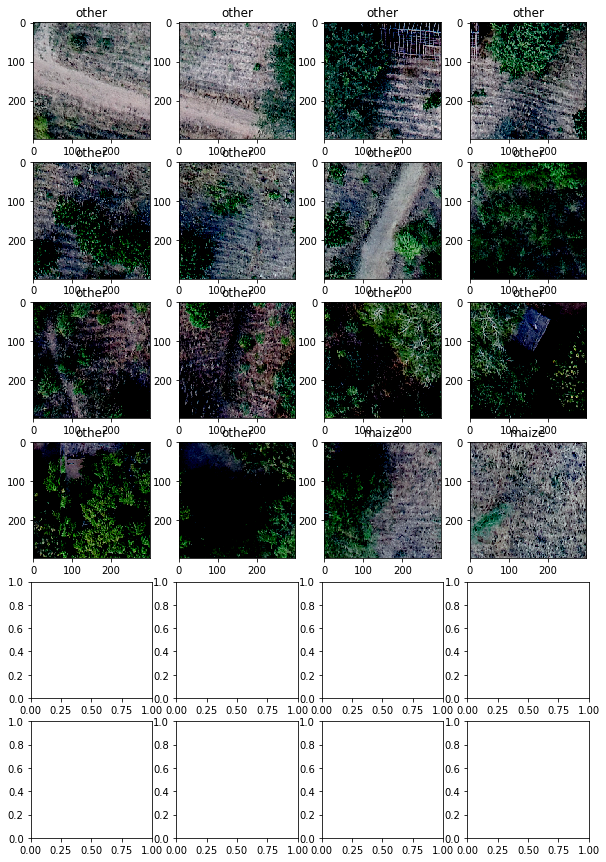

In [22]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6, 4, figsize=(10, 15))

class_indices = np.argmax(batch_predictions, axis=1)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(batch[i])
    ax.set_title(hyperparameters['classes'][class_indices[i]])
fig.tight_layout()